<a href="https://colab.research.google.com/github/Stavroskiig/SVM-CIFAR-10/blob/main/NN_2nd_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

2η Υποχρεωτική Εργασία


---
* **Στόχος**:
Ζητούμενο της εργασίας είναι να γραφεί πρόγραμμα σε οποιαδήποτε γλώσσα προγραμματισμού το οποίο να υλοποιεί ένα **Support Vector Machine**. Το SVM αυτό θα εκπαιδευτεί για να επιλύει το πρόβλημα του διαχωρισμού 2 κλάσεων που υπάρχουν στο τροποιημένο μου **CIFAR-10**.

* **Γλώσσα**:
Επιλέγω να εργαστώ σε **Python**.

* **Βάση Δεδομένων**:
Για την εκπαίδευση και την κατηγοριοποίηση αποφάσισα να χρησιμοποιήσω την βάση δεδομένων CIFAR-10 που υπάρχει στην παρακάτω διεύθυνση:
https://www.cs.toronto.edu/~kriz/cifar.html


---



Ιδανικά ανοίξτε το notebook στο colab για να φαίνονται και οι εικόνες που ετοίμασα (είναι ανεβασμένες στο drive λόγω χώρου).

---

# Προεπεξεργασία του CIFAR-10

Παίρνω το dataset από την keras. Βεβαίως απαιτείται πρώτα να εισάγω την TensorFLow.



In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


Αυτό μου επιστρέφει:
* **x_train**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (50000, 32, 32, 3), που περιέχουν τα δεδομένα εκπαίδευσης (train). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_train**: uint8 NumPy πίνακας ετικετών (labels) (ακέραιοι του εύρους 0-9) με shape (50000, 1) για τα δεδομένα εκπαίδευσης (train).

* **x_test**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (10000, 32, 32, 3), που περιέχουν τα δεδομένα δοκιμής (test). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_test**: uint8 NumPy πίνακας ετικετών (ακέραιοι στο εύρος 0-9) με shapes (10000, 1) για τα δεδομένα δοκιμής (test).

Θα δω τα shapes των συνόλων. Τα `x` σύνολα περιλαμβάνουν τις εικόνες, ενώ τα `y` τις ετικέτες.

In [ ]:
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test: (10000, 32, 32, 3) y_test: (10000, 1)


* Τα `x_train` και `x_test` έχουν το shape: (πλήθος εικόνων, ύψος, πλάτος, πλήθος καναλιών).
* Τα `y_train` και `y_test` είναι 2D πίνακες με shape: (πλήθος εικόνων, 1)

Τώρα θέλω να διατηρήσω μόνο δύο κλάσεις από το σύνολο δεδομένων CIFAR-10. Για αυτό θα φιλτράρω τα δεδομένα με βάση τις κλάσεις που θέλετε να κρατήσω. Επιλέγω τα αεροπλάνα (index 0) και τα πλοία (index 8).

In [ ]:
chosen_classes = [0, 8]

Ορίζω την συνάρτηση φιλτραρίσματος, η οποία παίρνει ως παραμέτρους ένα σύνολο x και τις κλάσεις που έχω επιλέξει. Το tf.equal επιστρέφει έναν boolean τένσορα με την τιμή True όπου η κλάση του παραδείγματος ταιριάζει με τις επιλεγμένες κλάσεις, ενώ False στις υπόλοιπες.

In [ ]:
import numpy as np

def filter_dataset(x, y, chosen_classes):
    y = y.flatten()
    train_mask = np.isin(y, chosen_classes)
    x_filtered = x[train_mask]
    y_filtered = y[train_mask]
    return x_filtered, y_filtered

Τώρα φιλτράρω τα σύνολα.

In [ ]:
x_train_filtered, y_train_filtered = filter_dataset(x_train, y_train, chosen_classes)
x_test_filtered, y_test_filtered = filter_dataset(x_test, y_test, chosen_classes)

In [ ]:
print(x_train.shape, x_train_filtered.shape)
print(y_train.shape, y_train_filtered.shape)

print(x_test.shape, x_test_filtered.shape)
print(y_test.shape, y_test_filtered.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000,)
(10000, 32, 32, 3) (2000, 32, 32, 3)
(10000, 1) (2000,)


Μετατρέπω τα σύνολα σε `float32`.

In [ ]:
x_train_filtered, x_test_filtered = np.array(x_train_filtered, dtype=np.float32), np.array(x_test_filtered, dtype=np.float32)

Θα κάνω flatten τις εικόνες από 3D σε διανύσματα 1D.

In [ ]:
number_features = 3072

x_train_filtered = x_train_filtered.reshape([-1, number_features])
x_test_filtered = x_test_filtered.reshape([-1, number_features])

print("x_train:", x_train_filtered.shape, "x_test:", x_test_filtered.shape)

x_train: (10000, 3072) x_test: (2000, 3072)


Θα τις κανονικοποιήσω στο εύρος [0,1].

In [ ]:
x_train_filtered = x_train_filtered/255.0
x_test_filtered = x_test_filtered/255.0

Κρατώ τον αριθμό των κλάσεων και των υπερκλάσεων για το μέλλον.

In [ ]:
number_classes = 2
number_features = 3072

Εφαρμόζω PCA για την εξαγωγή χαρακτηριστικών.

In [ ]:
import time
from sklearn.decomposition import PCA

start = time.time()

pca = PCA(n_components=0.9).fit(x_train_filtered)
x_train_pca = pca.transform(x_train_filtered)
x_test_pca = pca.transform(x_test_filtered)

end = time.time()
print("PCA elapsed time: {} seconds\n".format(end - start))
print("Extracted {} features from the original {}.".format(x_train_pca.shape[1], x_train_filtered.shape[1]))
print("Cumulative explained variation for {} principal components: {:.2%}".format(x_train_pca.shape[1], np.sum(pca.explained_variance_ratio_)))

PCA elapsed time: 38.523391008377075 seconds

Extracted 76 features from the original 3072.
Cumulative explained variation for 76 principal components: 90.07%


Κρατώντας μόλις 76 features από τα 3072, δηλαδή το 2.47%, καταφέρνω να κρατήσω περισσότερο από το 90% της πληροφορίας.

# k-NN Models

Εισάγω από την κατάλληλη βιβλιοθήκη (`sklearn`) τον κατηγοριοποιητή πλησιέστερου γείτονα.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Ορίζω τις συναρτήσεις train και test αντίστοιχα.

In [ ]:
def train_knn_classifier(x_train, y_train, n_neighbors, metric):
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

    start_time = time.time()
    knn_classifier.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f}s\n")

    return knn_classifier

In [ ]:
def test_knn_classifier(knn_classifier, x_test, y_test):
    start_time = time.time()
    score = knn_classifier.score(x_test, y_test)
    end_time = time.time()

    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f}s\n")

    return score

* **1-NN Model**

Αρχικά φτιάχνω τον κατηγοριοποιητή ενός κοντινού γείτονα με `p=2`, δηλαδή επιλέγοντας την ευκλείδια απόσταση ως υπερπαράμετρο της μετρικής Minkowski.

Η απόσταση Minkowski είναι μια γενικευμένη απόσταση σε έναν κανονικοποιημένο διανυσματικό χώρο. Ακολουθεί ο τύπος που την ορίζει. Για c ίσο με 1, ο τύπος δίνει την απόσταση Manhattan. Όταν το c είναι ίσο με 2, δίνει την Euclidean απόσταση.

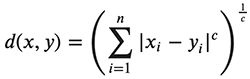

Η ευκλείδια απόσταση σύμφωνα με το σχήμα υπολογίζεται ως εξής. Αφαιρώ το X1 από το X2, τετραγωνίζω το αποτελέσμα, κάνω το ίδιο για τα Y1 και Y2, προσθέτω τα δύο τετράγωνα και στο τέλος τα "βάζω" κάτω από τετραγωνική ρίζα.

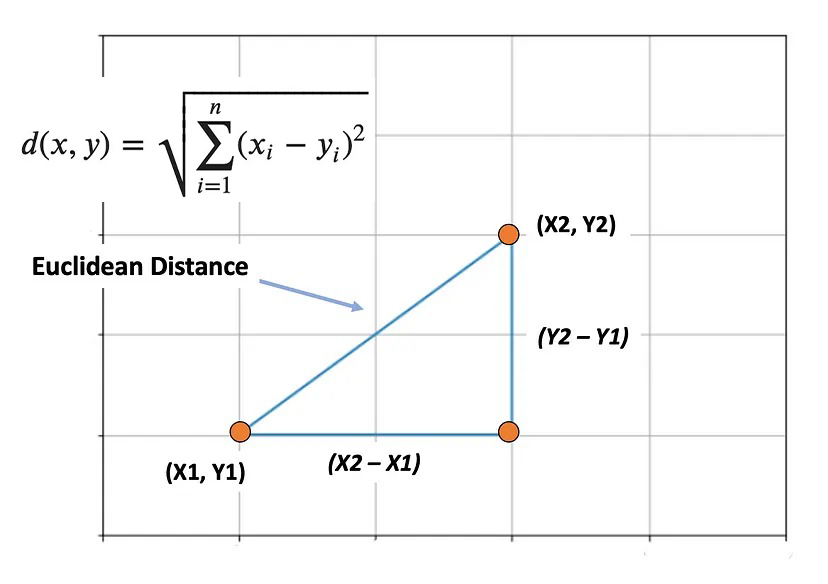

Συνεχίζω τώρα με το κατηγοριοποιητή. Αρχικά χωρίς PCA, έπειτα με PCA.

In [ ]:
knn_classifier_1 = train_knn_classifier(x_train_filtered, y_train_filtered, n_neighbors=1, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_1, x_test_filtered, y_test_filtered)

print(f"For the 1-NN classifier with Euclidean distance metric without PCA the accuracy is: {accuracy:.4f}\n")


knn_classifier_1_pca = train_knn_classifier(x_train_pca, y_train_filtered, n_neighbors=1, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_1_pca, x_test_pca, y_test_filtered)

print(f"For the 1-NN classifier with Euclidean distance metric with PCA the accuracy is: {accuracy:.4f}")

Training time: 0.0337s

Testing time: 5.8783s

For the 1-NN classifier with Euclidean distance metric without PCA the accuracy is: 0.7455

Training time: 0.0025s

Testing time: 0.2741s

For the 1-NN classifier with Euclidean distance metric with PCA the accuracy is: 0.7510


Πετυχαίνω **0.7455** ακρίβεια χωρίς PCA, ενώ με PCA **0.7510** και μάλιστα σε αρκετά μικρότερο χρόνο. Τώρα θα δοκιμάσω αν αλλάζει κάτι ελέγχοντας τρεις γείτονες.

* **3-NN Model**

In [ ]:
knn_classifier_3 = train_knn_classifier(x_train_filtered, y_train_filtered, n_neighbors=3, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_3, x_test_filtered, y_test_filtered)

print(f"For the 3-NN classifier with Euclidean distance metric without PCA the accuracy is: {accuracy:.4f}\n")

knn_classifier_3_pca = train_knn_classifier(x_train_pca, y_train_filtered, n_neighbors=3, metric='euclidean')

accuracy = test_knn_classifier(knn_classifier_3_pca, x_test_pca, y_test_filtered)

print(f"For the 3-NN classifier with Euclidean distance metric with PCA the accuracy is: {accuracy:.4f}")

Training time: 0.0177s

Testing time: 4.1693s

For the 3-NN classifier with Euclidean distance metric without PCA the accuracy is: 0.7395

Training time: 0.0025s

Testing time: 0.2514s

For the 3-NN classifier with Euclidean distance metric with PCA the accuracy is: 0.7540


Παρατηρώ πως χρειάζεται λιγότερο χρόνο και η ακρίβεια με PCA είναι υψηλότερη από τις προηγούμενες με τιμή **0.7540**.

# Nearest Centroid Models

Ο Nearest Centroid Classifier (NCC) είναι ένα μοντέλο ταξινόμησης που αποδίδει σε παρατηρήσεις την ετικέτα της κατηγορίας δειγμάτων εκπαίδευσης των οποίων ο μέσος όρος (κεντροειδές/centroid) είναι πλησιέστερος στην παρατήρηση.

Μιλώντας με μαθηματικούς όρους, δεδομένου του συνόλου $\left \{ \left ( \vec{x_{1}}, \vec{y_{1}} \right ),..., \left ( \vec{x_{n}}, \vec{y_{n}} \right ) \right \}$, με τα $y_{i}\in \mathbf{Y}$ να είναι οι ετικέτες των κλάσεων, υπολογίζει τους centroids ανά κλάση ως $\vec{\mu _{l}}=\frac{1}{\left | C_{l} \right |}\sum _{i\in C_{l}}\vec{x_{i}}$, όπου $C_{l}$ είναι το σύνολο των δειγμάτων που ανήκουν στην κλάση $l\in \mathbf{Y}$.

Στην φάση της πρόβλεψης η κλάση που αποδίδεται σε μία παρατήρηση $\vec{x}$ είναι το αποτελέσμα του $\hat{y}=\arg \min _{l\in \mathbf{Y}}\left \| \vec{\mu _{l}} - \vec{x} \right \|$.

Όμοια με πριν, θα ορίσω πρώτα τις συναρτήσεις εκπαίδευσης και δοκιμής για καλύτερη ευελιξία.

In [ ]:
from sklearn.neighbors import NearestCentroid

In [ ]:
def train_nearest_centroid_classifier(x_train, y_train, metric):
    ncc_classifier = NearestCentroid(metric=metric)

    start_time = time.time()
    ncc_classifier.fit(x_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f}s\n")

    return ncc_classifier

In [ ]:
def test_nearest_centroid_classifier(ncc_classifier, x_test, y_test):
    start_time = time.time()
    score = ncc_classifier.score(x_test, y_test)
    end_time = time.time()

    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f}s\n")

    return score

* **Ευκλείδια απόσταση**

Τώρα θα τεστάρω τον κατηγοριοποιητή `NearestCentroid`, αρχικά με μετρική την Ευκλείδια απόσταση. Πάλι θα δοκιμάσω αν βοηθάει η εφαρμογή του PCA.

In [ ]:
ncc_classifier_euclidean = train_nearest_centroid_classifier(x_train_filtered, y_train_filtered, metric='euclidean')

accuracy = test_nearest_centroid_classifier(ncc_classifier_euclidean, x_test_filtered, y_test_filtered)

print(f"For the Nearest Centroid classifier with Euclidean distance metric without PCA the accuracy is: {accuracy:.4f}\n")

ncc_classifier_euclidean_pca = train_nearest_centroid_classifier(x_train_pca, y_train_filtered, metric='euclidean')

accuracy = test_nearest_centroid_classifier(ncc_classifier_euclidean_pca, x_test_pca, y_test_filtered)

print(f"For the Nearest Centroid classifier with Euclidean distance metric with PCA the accuracy is: {accuracy:.4f}")

Training time: 0.0793s

Testing time: 0.0408s

For the Nearest Centroid classifier with Euclidean distance metric without PCA the accuracy is: 0.6585

Training time: 0.0034s

Testing time: 0.0025s

For the Nearest Centroid classifier with Euclidean distance metric with PCA the accuracy is: 0.6580


Παρατηρώ πως είναι πολύ γρήγορο, αλλά με χειρότερη ακρίβεια και στις δύο περιπτώσεις (**0.6585** και **0.6580**) σε σχέση με τα k-NN. Θα δοκιμάσω να αλλάξω την μετρική στην απόσταση Μανχάταν.

* **Απόσταση Μανχάταν**

Η απόσταση Manhattan διαφέρει από την Ευκλείδια όταν υπολογίζουμε την διαφορά  μεταξύ δύο σημείων χρησιμοποιώντας την απόλυτη τιμή της διαφοράς. Με άλλα λόγια, η απόσταση μεταξύ του σημείου x και του y ισούται με το άθροισμα των απόλυτων διαφορών του Y με το X σε κάθε διάσταση.

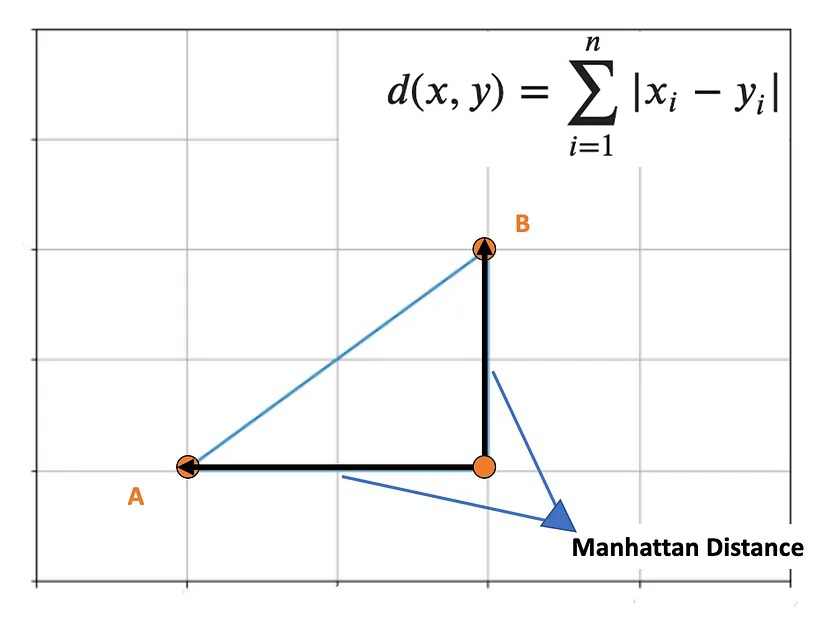

In [ ]:
ncc_classifier_manhattan = train_nearest_centroid_classifier(x_train_filtered, y_train_filtered, metric='manhattan')

accuracy = test_nearest_centroid_classifier(ncc_classifier_manhattan, x_test_filtered, y_test_filtered)

print(f"For the Nearest Centroid classifier with Manhattan distance metric without PCA the accuracy is: {accuracy:.4f}\n")

ncc_classifier_manhattan_pca = train_nearest_centroid_classifier(x_train_pca, y_train_filtered, metric='manhattan')

accuracy = test_nearest_centroid_classifier(ncc_classifier_manhattan_pca, x_test_pca, y_test_filtered)

print(f"For the Nearest Centroid classifier with Manhattan distance metric without PCA the accuracy is: {accuracy:.4f}")

Training time: 0.9819s

Testing time: 0.0429s

For the Nearest Centroid classifier with Manhattan distance metric without PCA the accuracy is: 0.6590

Training time: 0.0169s

Testing time: 0.0026s

For the Nearest Centroid classifier with Manhattan distance metric without PCA the accuracy is: 0.6775


Τώρα είναι πιο αργό και ελάχιστα πιο ακριβές (**0.6590** και **0.6775**) από πριν.

# Ο Αλγόριθμος Support Vector Machine (SVM)


Το Support Vector Machine/Network είναι ένας εποπτευόμενος (supervised) αλγόριθμος μηχανικής μάθησης που χρησιμοποιείται για προβλήματα ταξινόμησης κυρίως, αλλά και παλινδρόμησης. Όπως προκύπτει και από την εκφώνηση εγώ θέλω να επιλύσω το πρόβλημα του διαχωρισμού 2 κλάσεων που διάλεξα στο CIFAR-10.

Πρώτα θα αναφέρω κάποιες βασικές έννοιες του αλγορίθμου.

* **Υπερεπίπεδο**: Ένα υπερεπίπεδο ή όριο ή επιφάνεια απόφασης είναι ένας ν-διάστατος Ευκλείδειος χώρος που χωρίζει με ευδιάκριτο τρόπο τα σημεία του συνόλου δεδομένων. Τα σημεία σε κάθε πλευρά του υπερεπίπεδου ανήκουν σε διαφορετικές κλάσεις. Εάν έχουμε ένα σύνολο χαρακτηριστικών p-διάστασης, η διάσταση του υπερεπίπεδου θα είναι p-1.

* **Support Vectors**: Τα μεμονωμένα σημεία που βρίσκονται κοντά στο υπερεπίπεδο.

* **Margin**: Το πλάτος που θα μπορούσε να αυξηθεί το όριο πριν φτάσει σε ένα σημείο. Με απλά λόγια, είναι η απόσταση μεταξύ του υπερεπίπεδου και των support vectors.

Στην παρακάτω εικόνα φαίνονται οπτικά αυτές οι έννοιες.

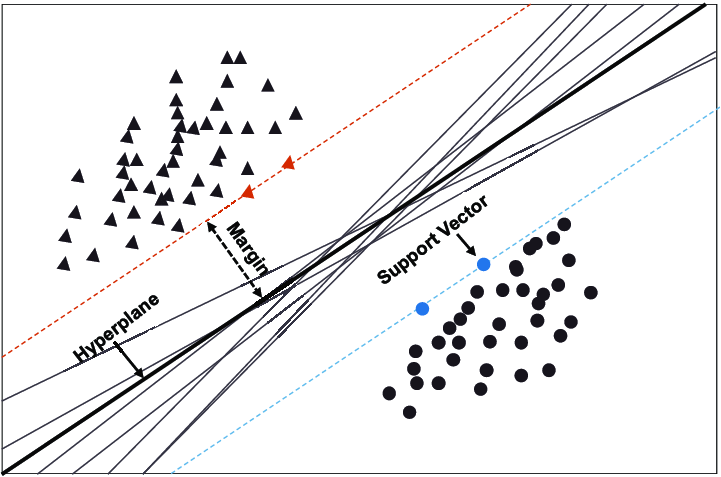

* **Linear separability**: Ένα σύνολο δεδομένων είναι γραμμικά διαχωρίσιμο, αν υπάρχει τουλάχιστον μία ευθεία γραμμή που διαχωρίζει με σαφή τρόπο τις κλάσεις.

* **Non-linear separability**: Ένα σύνολο δεδομένων λέγεται ότι είναι μη γραμμικά διαχωρισμό, αν δεν υπάρχει καμία γραμμή που διαχωρίζει με σαφή τρόπο τις κλάσεις.

![alt](https://drive.google.com/uc?id=1bXDaBVuAmYPJNRrBzQC1sqO3jbEwp_-1)

Τώρα θα περιγράψω την λειτουργία του αλγορίθμου.

Στο SVM, τα δεδομένα του χώρου, πεπερασμένων διαστάσεων, αντιστοιχίζονται σε κάποια υψηλότερη διάσταση (p-διάσταση) και στοχεύουν στην εύρεση του υπερεπίπεδου διάστασης p-1 που ονομάζεται linear classifier.

Εάν τα δεδομένα είναι γραμμικά διαχωρίσιμα, εκτός από την εύρεση του υπερεπίπεδου διάστασης p-1, το SVM δημιουργεί δύο παράλληλα υπερεπίπεδα και στις δύο πλευρές που διέρχονται από τα πλησιέστερα σημεία (support vectors). Η περιοχή που οριοθετείται από αυτά τα δύο υπερεπίπεδα ονομάζεται margin.

Θα μπορούσαν να υπάρχουν πολλά τέτοια υπερεπίπεδα που μπορούν να ταξινομήσουν ικανοποιητικά τα δεδομένα. Το πιο σταθερό υπερεπίπεδο είναι αυτό που έχει το μέγιστο margin. Το margin είναι η απόσταση μεταξύ των δύο κλάσεων. Το υπερεπίπεδο που έχει το μέγιστο margin ονομάζεται υπερεπίπεδο μέγιστου margin και ο ταξινομητής που προκύπτει από αυτό είναι γνωστός ως ταξινομητής μέγιστου margin.

![alt](https://drive.google.com/uc?id=13kiA6S5r8jJH2U0XQtk8_-6hYRda8Cl2)

Στο παραπάνω σχήμα, δεν ταξινομεί το υπερεπίπεδο H1 τα σημεία δεδομένων, αλλά το H2. Έχει όμως το μικρότερο margin. Το H3 είναι ο καλύτερος ταξινομητής, καθώς ταξινομεί καλά τα σημεία και έχει το υψηλότερο margin.

Συνοψίζοντας, το SVM χρησιμοποιείται για να διαχωρίσει γραμμικά τις κλάσεις της μεταβλητής εξόδου σχεδιάζοντας έναν ταξινομητή/υπερεπίπεδο, όπου για έναν δισδιάστατο χώρο αυτό είναι μια γραμμή, ενώ για έναν τρισδιάστατο χώρο είναι ένα επίπεδο.

Αν τα δεδομένα είναι μη γραμμικώς διαχωρίσιμα, πρέπει να εφαρμόσω μετασχηματισμούς που αντιστοιχίζουν τα αρχικά δεδομένα σε κάποια μεγαλύτερη διάσταση. Μετά τον μετασχηματισμό, τα δεδομένα θα είναι γραμμικά διαχωρίσιμα και μπορώ να βρω ένα υπερεπίπεδο για την ταξινόμηση.

Αν έχω έναν μη διαχειρίσιμο αριθμό χαρακτηριστικών χρησιμοποιώ κάποιον πυρήνα. Αφού εφαρμοστεί ο πυρήνας, το "πλάτος" αντιστοιχίζεται σε μια νέα διάσταση, ας την πούμε "ύψος". Έτσι, το διάγραμμα "πλάτους" με "μήκος" αντιστοιχίζεται σε ένα "ύψους" με "μήκος".

![alt](https://drive.google.com/uc?id=1OqqKnJSrJlkyIB0ThtahyyA64e3IsGxE)

## Kernel Functions

Οι συνηθισμένες συναρτήσεις kernel περιλαμβάνουν τις:

* **Linear** (Γραμμική):

$k(x, y) = x\cdot y^T$

Επίσης γνωστός ως πυρήνας dot product (εσωτερικού γινομένου). Δεν μετασχηματίζει τα δεδομένα.

In [ ]:
def linear_kernel(x1, x2):
    return torch.matmul(x1, x2.t())

* **Polynomial**:

$K(x,y)=(γx\cdot y^T +c)^d$

όπου το c είναι ο συντελεστής και d ο βαθμός του πολυωνυμικού πυρήνα. Είναι ένας απλός μη γραμμικός μετασχηματισμός που προσθέτει την διάσταση του πολυωνύμου.



In [ ]:
def polynomial_kernel(x, y, d, c, gamma):
    return (gamma * torch.matmul(x, y.t()) + c)**d

* **Radial Basis Function** (RBF):

$K(x, y) = \exp \left( - \frac{||x-y||^2}{2σ^2} \right) = \exp \left( -{γ||x-y||^2}\right)$

όπου το σ προκύπτει από το cross-validation και $\gamma = \frac{1}{2\sigma ^{2}}$. Είναι ο πιο διαδεδομένος πυρήνας για μη γραμμικά δεδομένα. Λέγεται επίσης και Gaussian.

In [ ]:
def rbf_kernel(x, y, gamma):
    return torch.exp(-gamma * torch.norm(x - y)**2)

* **Sigmoid**:

$K(x, y) = \tanh(γx \cdot y^T + c)$

όπου τα γ, c προκύπτουν από το cross-validation.


In [ ]:
def sigmoid_kernel(x, y, gamma, c):
    return torch.tanh(gamma * torch.matmul(x, y.t()) + c)

Με απλά λόγια, ένας πυρήνας δεν είναι παρά ένας μετασχηματισμός που εφαρμόζουμε στα υπάρχοντα χαρακτηριστικά, ώστε να μπορώ να σχεδιάσω εύκολα έναν ταξινομητή για μη γραμμικά διαχωρίσιμα σημεία.

# SVM from sklearn

Σε αυτό το μέρος, θα χρησιμοποιήσω την βιβλιοθήκη scikit-learn για να υλοποιήσω κάποια Support Vector Machines (SVM) για την κατηγοριοποίηση του cifar-10. Η `train_test_split` με βοηθάει στον διαχωρισμό των training και testing σετς. Χρησιμοποιώ την `SVC` (Support Vector Classification) για τα περισσότερα μοντέλα και την `LinearSVC` για ένα έξτρα γραμμικό μοντέλο, ώστε να τα εκπαιδεύσω. Επιπλέον, χρησιμοποιώ και metrics για την απόδοσή τους, όπως την ακρίβεια και το `classification_report` που παράγει μία συνολική αναφορά..


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report

* **Linear**:

Εδώ θα εφαρμόσω έναν γραμμικό (linear) πυρήνα (kernel). Συνήθως είναι κατάλληλος για γραμμικώς διαχωριζόμενα δεδομένα και το SVM στοχεύει να βρει το βέλτιστο υπερεπίπεδο που διαχωρίζει τις κλάσεις του dataset.

In [ ]:
start_time = time.time()
svm = SVC(kernel='linear')
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 48.32 seconds
Training Accuracy: 71.85%
Test Accuracy: 72.55%

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1000
           8       0.72      0.75      0.73      1000

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



In [ ]:
start_time = time.time()
svm = LinearSVC()
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 5.96 seconds
Training Accuracy: 71.29%
Test Accuracy: 71.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71      1000
           8       0.71      0.74      0.73      1000

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


* **Polynomial**:

In [ ]:
start_time = time.time()
svm = SVC(kernel='poly')
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 9.12 seconds
Training Accuracy: 84.63%
Test Accuracy: 77.70%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1000
           8       0.74      0.86      0.79      1000

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



* **Radial Basis Function** (RBF):

In [ ]:
start_time = time.time()
svm = SVC(kernel='rbf')
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 5.64 seconds
Training Accuracy: 87.92%
Test Accuracy: 82.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1000
           8       0.81      0.84      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



* **Sigmoid**:

In [ ]:
start_time = time.time()
svm = SVC(kernel='sigmoid')
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

y_test_pred = svm.predict(x_test_pca)
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 5.80 seconds
Training Accuracy: 56.06%
Test Accuracy: 55.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1000
           8       0.55      0.56      0.56      1000

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000



## Fine Tuning

Παρακάτω θα χρησιμοποιήσω το Optuna, το οποίο είναι μια βιβλιοθήκη για την εύρεση βέλτιστων υπερπαραμέτρων. Θα εξετάσω υπερπαράμετρους όπως η παράμετρος κανονικοποίησης C, η συνάρτηση πυρήνα (γραμμική, rbf, πολυωνυμική, σιγμοειδής), ο συντελεστής c,η παράμετρος γ, αλλά και ο βαθμός του πολυωνύμου στην περίπτωση του πολυωνυμικού πυρήνα. Αυτές είναι που επηρεάζουν την ικανότητα του SVM να γενικεύει.

Η αντικειμενική συνάρτηση ορίζεται για την εκπαίδευση ενός μοντέλου SVM με τις δοκιμαζόμενες υπερπαραμέτρους και την αξιολόγηση της απόδοσής του σε ένα σύνολο δοκιμής. Ως μετρική για την βελτιστοποίηση επιλέγω την ακρίβεια.

Δημιουργείται η μελέτη (study) Optuna και η αντικειμενική συνάρτηση βελτιστοποιείται για έναν καθορισμένο αριθμό δοκιμών. Τέλος, εκτυπώνονται οι καλύτερες υπερπαράμετροι που βρέθηκαν κατά τη βελτιστοποίηση.

In [ ]:
!pip install optuna

Ξεκινώ με τα απαραίτητα imports.

In [ ]:
import optuna

Καθορίζω την αντικειμενική συνάρτηση για το Optuna.
Η παράμετρος που έχει συνήθως τον πιο σημαντικό αντίκτυπο στον χρόνο εκπαίδευσης είναι η παράμετρος C που λέγχει την αντιστάθμιση μεταξύ της ύπαρξης ομαλού ορίου απόφασης και της σωστής ταξινόμησης των σημείων εκπαίδευσης. Ένα μικρότερο C προωθεί ένα απλούστερο όριο απόφασης, ενώ ένα μεγαλύτερο C στοχεύει να ταξινομήσει σωστά όλα τα σημεία εκπαίδευσης, οδηγώντας ενδεχομένως σε ένα πιο περίπλοκο όριο απόφασης.

In [ ]:
def objective(trial):

    C = trial.suggest_categorical('C', [0.001, 0.01, 0.1, 1, 10, 100])
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto', 0.001, 0.01, 0.1, 1.0, 10.0, 100.0])
    coef0 = trial.suggest_categorical('coef0', [-1.0, -0.1, 0.0, 0.1, 1.0])
    degree = trial.suggest_categorical('degree', [2, 3, 4, 5])

    svm = SVC(C=C, kernel=kernel, gamma=gamma, coef0=coef0, degree=degree)

    svm.fit(x_train_pca, y_train_filtered)

    y_test_pred = svm.predict(x_test_pca)
    test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

    return test_accuracy

Δημιουργώ την μελέτη Optuna και βελτιστοποιώ.

In [ ]:
start_time = time.time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
optimize_time = time.time() - start_time

print('Best Hyperparameters:', best_params)
print(f'Optimization Time: {optimize_time:.2f} seconds')

[I 2023-12-19 13:59:30,821] A new study created in memory with name: no-name-130882e1-d424-4718-8a43-811a3878834c
[I 2023-12-19 13:59:49,019] Trial 0 finished with value: 0.8315 and parameters: {'C': 10, 'kernel': 'rbf', 'gamma': 'scale', 'coef0': 0.1, 'degree': 5}. Best is trial 0 with value: 0.8315.
[I 2023-12-19 14:00:04,027] Trial 1 finished with value: 0.726 and parameters: {'C': 0.1, 'kernel': 'linear', 'gamma': 1.0, 'coef0': 0.1, 'degree': 3}. Best is trial 0 with value: 0.8315.
[I 2023-12-19 14:00:12,709] Trial 2 finished with value: 0.5145 and parameters: {'C': 1, 'kernel': 'sigmoid', 'gamma': 1.0, 'coef0': 0.1, 'degree': 2}. Best is trial 0 with value: 0.8315.
[I 2023-12-19 14:00:26,209] Trial 3 finished with value: 0.719 and parameters: {'C': 0.001, 'kernel': 'rbf', 'gamma': 'auto', 'coef0': 0.1, 'degree': 2}. Best is trial 0 with value: 0.8315.
[I 2023-12-19 14:00:35,884] Trial 4 finished with value: 0.675 and parameters: {'C': 0.01, 'kernel': 'poly', 'gamma': 'auto', 'coef

Best Hyperparameters: {'C': 100, 'kernel': 'rbf', 'gamma': 0.001, 'coef0': 1.0, 'degree': 5}
Optimization Time: 4061.57 seconds


## Το καλύτερο SVM

Όπως προκύπτει παραπάνω, το βέλτιστο μοντέλο στον χώρο αναζήτησης που επέλεξα προκύπτει για {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}. Δηλαδή είναι της μορφής:

$K(x, y) = \exp \left( -{0.001||x-y||^2}\right)$

Επομένως επιλέγω αυτό για να συνεχίσω και να το συγκρίνω με τα προηγούμενα.

In [ ]:
start_time = time.time()
svm = SVC(C=100, kernel='rbf', gamma=0.001, coef0=1.0, degree=5)
svm.fit(x_train_pca, y_train_filtered)
training_time = time.time() - start_time

y_train_pred = svm.predict(x_train_pca)
train_accuracy = accuracy_score(y_train_filtered, y_train_pred)

start_time = time.time()
y_test_pred = svm.predict(x_test_pca)
testing_time = time.time() - start_time
test_accuracy = accuracy_score(y_test_filtered, y_test_pred)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Testing Time: {testing_time:.2f} seconds")
print(f"Test Accuracy: {test_accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, y_test_pred))

Training Time: 13.96 seconds
Training Accuracy: 90.96%
Testing Time: 0.84 seconds
Test Accuracy: 83.70%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           8       0.84      0.83      0.84      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



## Προβλέψεις

Θα προβάλλω και θα συγκρίνω τις πραγματικές κλάσεις και τις προβλεπόμενες κλάσεις για ένα υποσύνολο εικόνων χρησιμοποιώντας το εκπαιδευμένο μοντέλο SVM. Επιλέγω να δείξω 10 εικόνες μαζί με τις πραγματικές τους κλάσεις και τις αντίστοιχες προβλεπόμενες. Κάνω reshape στις εικόνες στις αρχικές διαστάσεις 32x32x3. Στην λίστα `cifar10_labels` βάζω τις κλάσεις για το σύνολο δεδομένων CIFAR-10.

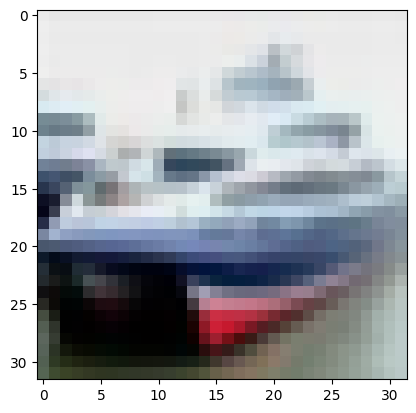

Actual class: ship, Predicted class: ship


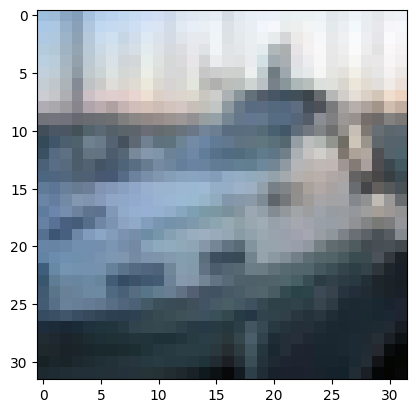

Actual class: ship, Predicted class: ship


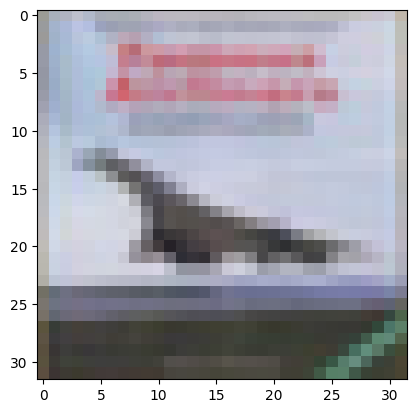

Actual class: airplane, Predicted class: airplane


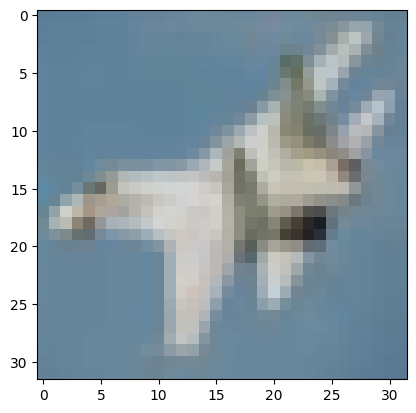

Actual class: airplane, Predicted class: ship


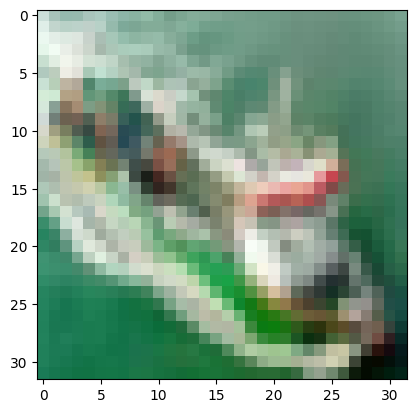

Actual class: ship, Predicted class: ship


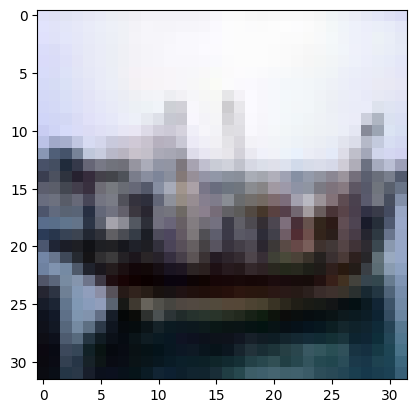

Actual class: ship, Predicted class: ship


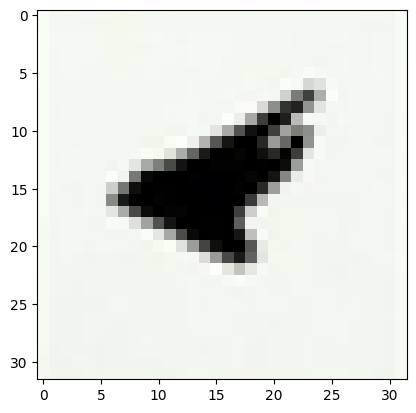

Actual class: airplane, Predicted class: airplane


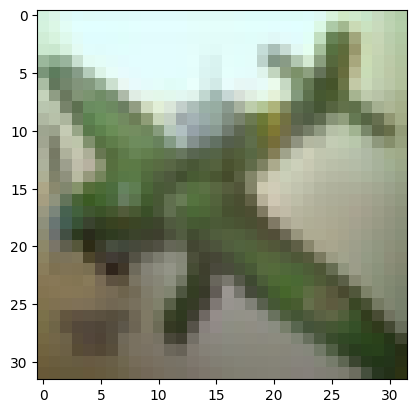

Actual class: airplane, Predicted class: airplane


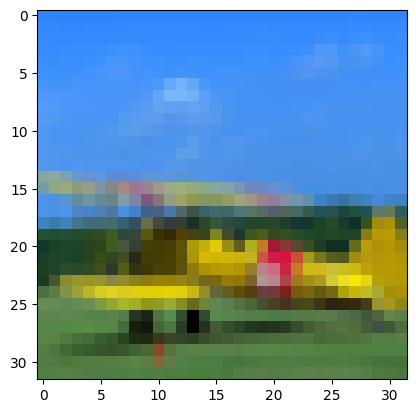

Actual class: airplane, Predicted class: airplane


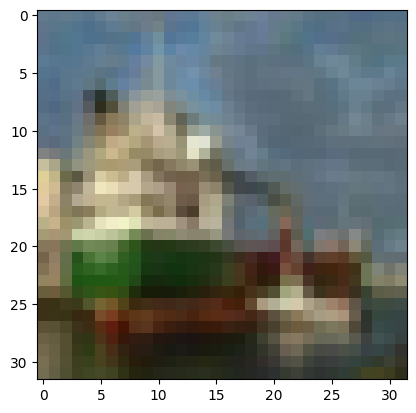

Actual class: ship, Predicted class: ship


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

n_images = 10
test_images = x_test_filtered[:n_images]

y_test_pred = svm.predict(x_test_pca[:n_images])

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [32, 32, 3]))
    plt.show()

    actual_class = cifar10_labels[y_test_filtered[i].item()]
    predicted_class = cifar10_labels[y_test_pred[i].item()]

    print("Actual class: {}, Predicted class: {}".format(actual_class, predicted_class))

Βλέπως πως στις συγκεκριμένες εικόνες είχε 90% επιτυχία. Προφανώς σε κάθε εκτέλεση λόγω στοχαστικότητας τα αποτελέσματα θα αλλάζουν λίγο. Επίσης, είναι ξεκάθαρο πως παίζει ρόλο και η επιλογή των συγκεκριμένων κλάσεων.

# Σύγκριση Μοντέλων

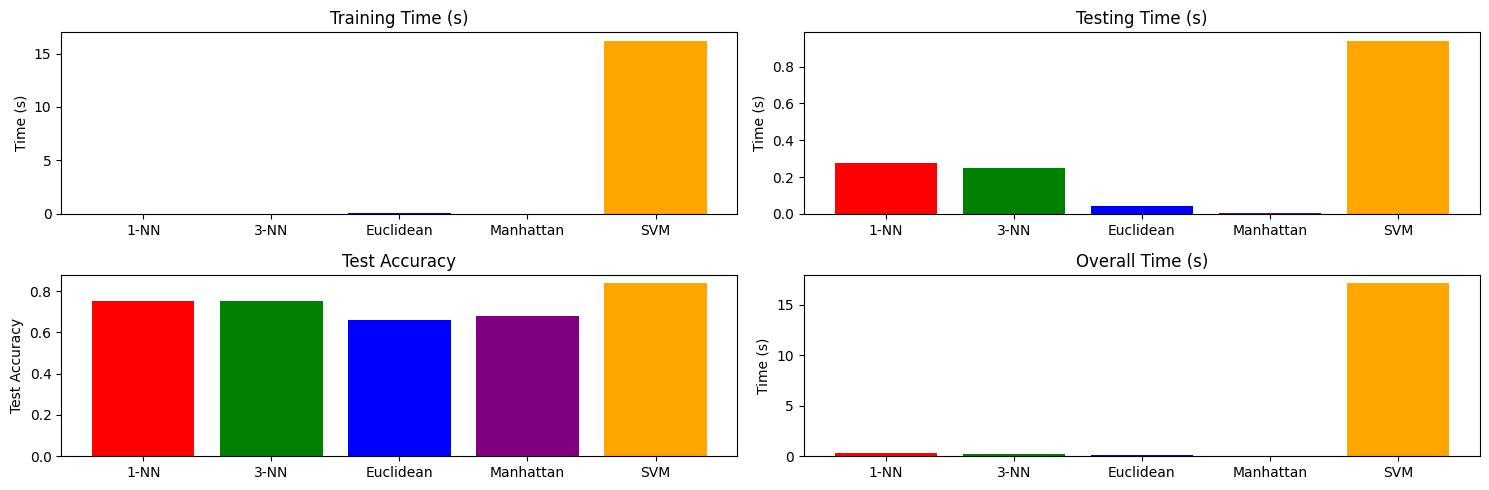

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ["1-NN", "3-NN", "Euclidean", "Manhattan", "SVM"]
test_accuracies = np.array([0.7510, 0.7540, 0.6585, 0.6775, 0.8370])
training_time = np.array([0.0025, 0.0025, 0.0793, 0.0169, 16.18])
testing_time = np.array([0.2741, 0.2514, 0.0408, 0.0026, 0.94])
overall_time = np.array(np.add(training_time, testing_time))

model_colors = {
    "1-NN": "red",
    "3-NN": "green",
    "Euclidean": "blue",
    "Manhattan": "purple",
    "SVM": "orange"
}

fig, axs = plt.subplots(2, 2, figsize=(15, 5))

# Subplot 1: Accuracy
accuracy_colors = [model_colors[model] for model in models]
axs[1][0].bar(models, test_accuracies, color=accuracy_colors)
axs[1][0].set_title("Test Accuracy")
axs[1][0].set_ylabel("Test Accuracy")

# Subplot 2: Training Time
training_time_colors = [model_colors[model] for model in models]
axs[0][0].bar(models, training_time, color=training_time_colors)
axs[0][0].set_title("Training Time (s)")
axs[0][0].set_ylabel("Time (s)")

# Subplot 3: Testing Time
testing_time_colors = [model_colors[model] for model in models]
axs[0][1].bar(models, testing_time, color=testing_time_colors)
axs[0][1].set_title("Testing Time (s)")
axs[0][1].set_ylabel("Time (s)")

# Subplot 4: Overall Time
overall_time_colors = [model_colors[model] for model in models]
axs[1][1].bar(models, overall_time, color=overall_time_colors)
axs[1][1].set_title("Overall Time (s)")
axs[1][1].set_ylabel("Time (s)")

plt.tight_layout()

plt.show()

Παρατηρώ πως το SVM είναι λίγο πιο ακριβές από τα υπόλοιπα έχοντας όμως συνολικά τουλάχιστον 15πλάσιο χρόνιο εκτέλεσης. Στο συγκεκριμένο πρόβλημα θα διάλεγα εν τέλει ένα k-NN μοντέλο. Παρ' όλα αυτά, βγαίνει το συμπέρασμα ότι το SVM με rbf πυρήνα είναι ικανό να λύσει αυτό το πρόβλημα 2 κλάσεων.